# Get the Data

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import scatter_matrix
import math

In [22]:
import tensorflow as tf
#from tensorflow import keras
import keras
print(tf.__version__)
print(keras.__version__)

2.16.1
3.0.5


## Define global constants

In [23]:
#MY_OPTIMIZER = "SGD"
# MY_EPOCHS = 1000
# MY_LEARNING_RATE = 0.000001
# MY_BATCH_SIZE = 2048
MY_EPOCHS = 1000
MY_LEARNING_RATE = 0.000001
MY_BATCH_SIZE = 128

# Get the Data

In [24]:
maneuvers = pd.read_csv("maneuvers_T8.csv")
#maneuvers.head()
maneuvers.shape

(2051, 8)

In [25]:
maneuvers.describe()

,t,x,y,z,dx,dy,dz,dv_st
count,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2.051000e+03
mean,3144.884951,-0.991178,0.004103,0.000259,0.002162,0.003702,-0.002206,4.941007e-12
std,1811.726067,0.000201,0.000351,0.000206,0.000462,0.001662,0.000211,2.665496e-12
min,9.177680,-0.991499,0.003267,-0.000134,0.001260,0.000577,-0.002587,-7.872237e-12
25%,1577.031315,-0.991355,0.003827,0.000085,0.001763,0.002276,-0.002381,2.655061e-12
50%,3144.884951,-0.991199,0.004180,0.000261,0.002183,0.003734,-0.002191,5.029840e-12
75%,4712.738586,-0.991011,0.004417,0.000433,0.002567,0.005142,-0.002054,7.198332e-12
max,6280.592222,-0.990760,0.004578,0.000666,0.002945,0.006713,-0.001731,1.115641e-11


## Add/Drop Features

Try adding new attribute "angle" = angle in the periodic orbit, which is essentially time/period.

In [26]:
# Drop dx and dz features, since they are almost proportional to y
#maneuvers = maneuvers.drop(["dx", "dz"], axis=1)

#maneuvers["angle"]=maneuvers["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers = maneuvers.drop(["t"], axis=1)


# Prepare the Data for Machine Learning Algorithms

In [27]:
# Let's separate the predictors and the labels
maneuvers_predictors = maneuvers.drop("dv_st", axis=1)
maneuvers_labels = maneuvers[["dv_st"]].copy()

# Convert dataframe to a numpy array before training, to avoid issues with dataframe headers.
maneuvers_predictors = maneuvers_predictors.to_numpy()
maneuvers_labels = maneuvers_labels.to_numpy()

#maneuvers_predictors.head()
#maneuvers_labels.head()

## Create a Train/Test/Validation Set

In [28]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
maneuvers_predictors, maneuvers_labels, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(
X_train_full, y_train_full)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
print(X_train[:4])

(1230, 6)
(411, 6)
(410, 6)
[[-9.91408797e-01  3.71747307e-03  4.64458490e-04  1.61972412e-03
   5.63189879e-03 -1.83017462e-03]
 [-9.91077730e-01  4.30444720e-03  1.35494079e-04  2.41387922e-03
   2.81748337e-03 -2.54727342e-03]
 [-9.91426715e-01  3.56402505e-03  4.92689685e-04  1.51510595e-03
   5.91482367e-03 -2.17055593e-03]
 [-9.91372702e-01  3.74240434e-03  4.33411014e-04  1.69009838e-03
   5.35627761e-03 -2.27722238e-03]]


In [29]:
# Scale all the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

X_train_scaled[:5]

array([[0.12185517, 0.34317069, 0.74783777, 0.21323666, 0.82385306,
        0.88403764],
       [0.56964385, 0.79111524, 0.33655533, 0.68502213, 0.36516357,
        0.04565393],
       [0.09762021, 0.22606808, 0.78313337, 0.15108591, 0.86996376,
        0.4860867 ],
       [0.17067636, 0.36219679, 0.70902117, 0.25504405, 0.7789327 ,
        0.36137945],
       [0.11302745, 0.24090146, 0.92939696, 0.17529387, 0.85118941,
        0.50443999]])

In [30]:
# Scale target variable dv_st as well.
# Rationale: dv_st takes very small values (10^{-8}), 
# so MSE may be tiny and not computed properly. Also, NN may converge faster?

scaler_target = MinMaxScaler()
y_train_scaled = scaler_target.fit_transform(y_train)
y_valid_scaled = scaler_target.transform(y_valid)
y_test_scaled = scaler_target.transform(y_test)
y_train_scaled[:5]

array([[0.17828923],
       [0.57056095],
       [0.03919561],
       [0.26792649],
       [0.17589531]])

In [31]:
# Try adding degree 2 polynomial features. This worked well for polynomial regression 
# (see supervised.py).
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_scaled = poly_features.fit_transform(X_train_scaled)
X_valid_scaled = poly_features.transform(X_valid_scaled)
X_test_scaled = poly_features.transform(X_test_scaled)

X_train_scaled[:5]

array([[0.12185517, 0.34317069, 0.74783777, 0.21323666, 0.82385306,
        0.88403764, 0.01484868, 0.04181712, 0.0911279 , 0.02598399,
        0.10039076, 0.10772456, 0.11776612, 0.25663601, 0.07317657,
        0.28272222, 0.30337581, 0.55926133, 0.15946643, 0.61610843,
        0.66111674, 0.04546987, 0.17567567, 0.18850923, 0.67873386,
        0.72831711, 0.78152255],
       [0.56964385, 0.79111524, 0.33655533, 0.68502213, 0.36516357,
        0.04565393, 0.32449411, 0.45065393, 0.19171668, 0.39021864,
        0.20801318, 0.02600648, 0.62586332, 0.26625405, 0.54193145,
        0.28888647, 0.03611752, 0.11326949, 0.23054785, 0.12289775,
        0.01536507, 0.46925533, 0.25014513, 0.03127395, 0.13334444,
        0.01667115, 0.00208428],
       [0.09762021, 0.22606808, 0.78313337, 0.15108591, 0.86996376,
        0.4860867 , 0.00952971, 0.02206881, 0.07644965, 0.01474904,
        0.08492605, 0.04745189, 0.05110678, 0.17704146, 0.0341557 ,
        0.19667104, 0.10988869, 0.61329787, 0.1183

In [32]:
import joblib
joblib.dump(scaler, 'scaler.gz')
joblib.dump(scaler_target, 'scaler_target.gz')

['scaler_target.gz']

In [33]:
cov=np.cov(X_train_scaled, rowvar=False)
cond = np.linalg.cond(cov)
max_eig = np.linalg.eigvals(cov).max()
print(f"condition number is {cond}, max eigenvalue {max_eig:.2f}")

condition number is 9116465663563232.0, max eigenvalue 1.14


# Building, Training, and Evaluating the Model

The output layer has a single neuron (since we only want to
predict a single value) and uses no activation function, and the loss function is the mean squared error. 

Since the dataset is quite noisy, we just use a single hidden layer with fewer neurons than before, to avoid overfitting.

In [34]:
model = keras.models.Sequential([
keras.layers.Dense(300, activation="relu", input_shape=X_train_scaled.shape[1:]),
keras.layers.Dense(100, activation="relu"),
keras.layers.Dense(1)
])
model.summary()

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 300)            │         8,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,601 (150.79 KB)

 Trainable params: 38,601 (150.79 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
#opt = keras.optimizers.SGD(learning_rate=MY_LEARNING_RATE)
opt = keras.optimizers.Adam(learning_rate=MY_LEARNING_RATE)
model.compile(loss="mean_squared_error", optimizer=opt)
history = model.fit(X_train_scaled, y_train_scaled, epochs=MY_EPOCHS, batch_size=MY_BATCH_SIZE,
                    validation_data=(X_valid_scaled, y_valid_scaled))

Epoch 1/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1136 - val_loss: 0.1069
Epoch 2/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1138 - val_loss: 0.1056
Epoch 3/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1100 - val_loss: 0.1044
Epoch 4/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1118 - val_loss: 0.1032
Epoch 5/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1115 - val_loss: 0.1020
Epoch 6/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1081 - val_loss: 0.1008
Epoch 7/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1103 - val_loss: 0.0996
Epoch 8/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1062 - val_loss: 0.0984
Epoch 9/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1063 - val_loss: 0.0973
Epoch 10/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1013 - val_loss: 0.0961
Epoch 11/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1031 - val_loss: 0.0950
Epoch 12/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0522 - val_loss: 0.0481
Epoch 69/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0532 - val_loss: 0.0475
Epoch 70/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0494 - val_loss: 0.0469
Epoch 71/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0519 - val_loss: 0.0464
Epoch 72/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0496 - val_loss: 0.0458
Epoch 73/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0501 - val_loss: 0.0452
Epoch 74/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0493 - val_loss: 0.0447
Epoch 75/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0494 - val_loss: 0.0441
Epoch 76/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0483 - val_loss: 0.0436
Epoch 77/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0494 - val_loss: 0.0430
Epoch 78/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0456 - val_loss: 0.0425
Epoch 79/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0231 - val_loss: 0.0204
Epoch 136/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0218 - val_loss: 0.0201
Epoch 137/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0205 - val_loss: 0.0198
Epoch 138/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0217 - val_loss: 0.0196
Epoch 139/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0216 - val_loss: 0.0193
Epoch 140/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0214 - val_loss: 0.0191
Epoch 141/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0211 - val_loss: 0.0188
Epoch 142/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0210 - val_loss: 0.0186
Epoch 143/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0209 - val_loss: 0.0183
Epoch 144/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0213 - val_loss: 0.0181
Epoch 145/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0193 - val_loss: 0.0179
Epoch 146/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107 - val_loss: 0.0095
Epoch 203/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107 - val_loss: 0.0094
Epoch 204/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0094
Epoch 205/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0093
Epoch 206/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0092
Epoch 207/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098 - val_loss: 0.0091
Epoch 208/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0091
Epoch 209/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097 - val_loss: 0.0090
Epoch 210/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0089
Epoch 211/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 - val_loss: 0.0088
Epoch 212/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0088
Epoch 213/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 270/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 271/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 272/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0063
Epoch 273/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_loss: 0.0063
Epoch 274/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 275/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 276/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 277/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 278/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 279/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 280/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 - val_loss: 0.0054
Epoch 337/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - val_loss: 0.0054
Epoch 338/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 - val_loss: 0.0054
Epoch 339/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 340/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050 - val_loss: 0.0053
Epoch 341/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 342/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 343/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 - val_loss: 0.0053
Epoch 344/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 - val_loss: 0.0053
Epoch 345/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050 - val_loss: 0.0053
Epoch 346/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 347/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 404/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch 405/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 406/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 407/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 - val_loss: 0.0048
Epoch 408/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 409/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 410/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 411/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 412/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch 413/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 - val_loss: 0.0048
Epoch 414/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 471/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 472/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040 - val_loss: 0.0045
Epoch 473/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - val_loss: 0.0045
Epoch 474/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040 - val_loss: 0.0045
Epoch 475/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 - val_loss: 0.0045
Epoch 476/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 477/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - val_loss: 0.0044
Epoch 478/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 - val_loss: 0.0044
Epoch 479/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - val_loss: 0.0044
Epoch 480/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - val_loss: 0.0044
Epoch 481/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 538/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 539/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 540/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 541/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 542/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 - val_loss: 0.0043
Epoch 543/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 544/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - val_loss: 0.0043
Epoch 545/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 546/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 547/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 548/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 605/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 606/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 607/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 608/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 609/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 610/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 611/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 612/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 613/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 614/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 615/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 672/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 673/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 674/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 675/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 676/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 677/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 678/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 679/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 680/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 681/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 682/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - val_loss: 0.0041
Epoch 739/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 740/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 741/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 742/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 743/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 744/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 745/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 746/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 747/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 748/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 749/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 806/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 807/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 808/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 809/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 810/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - val_loss: 0.0041
Epoch 811/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - val_loss: 0.0041
Epoch 812/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 813/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - val_loss: 0.0041
Epoch 814/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 815/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 816/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 873/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - val_loss: 0.0041
Epoch 874/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - val_loss: 0.0041
Epoch 875/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 876/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - val_loss: 0.0041
Epoch 877/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 878/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 879/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 880/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 881/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 882/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 883/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 940/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 941/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 942/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - val_loss: 0.0041
Epoch 943/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 944/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - val_loss: 0.0041
Epoch 945/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 946/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - val_loss: 0.0041
Epoch 947/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 948/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - val_loss: 0.0041
Epoch 949/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 950/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

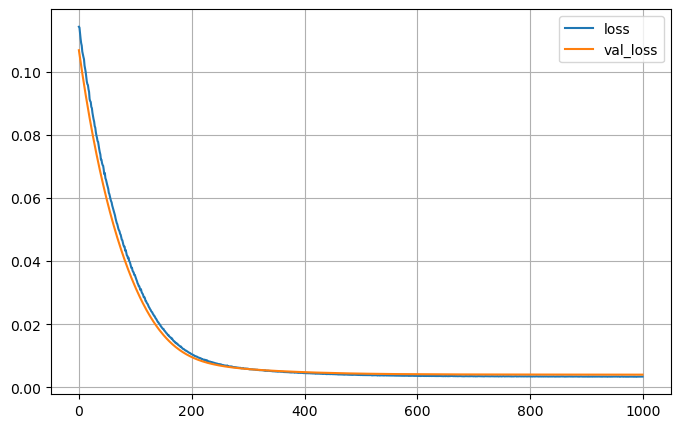

In [36]:
# Plot learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 5e-4) # set the vertical range to [0-1]
plt.show()

In [37]:
mse_test = model.evaluate(X_test_scaled, y_test_scaled)
np.sqrt(mse_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 0.0036


0.05890206046978349

In [38]:
X_new = X_test_scaled[:3] # pretend these are new instances
y_pred = model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [39]:
y_test_scaled[:3]

array([[0.33139998],
       [0.46833061],
       [0.15564322]])

In [40]:
y_pred[:3]

array([[0.35673338],
       [0.5509271 ],
       [0.2337457 ]], dtype=float32)

# Fine-Tuning Neural Network Hyperparameters

Wrap our Keras models in objects that mimic regular Scikit-Learn regressors.

def build_model(n_hidden, n_neurons, learning_rate, 
                input_shape):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", 
                                     **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

from scikeras.wrappers import KerasRegressor

keras_reg = KerasRegressor(build_model, n_hidden=1, n_neurons=30, learning_rate=3e-3, 
                input_shape=[8])

In [41]:
import keras
from keras import layers


def build_model(hp):
    model = keras.Sequential()
    #model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
               # Tune number of units separately for each layer.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
    model.add(layers.Dense(1))
    #learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        #optimizer=keras.optimizers.SGD(learning_rate=MY_LEARNING_RATE),
        optimizer=keras.optimizers.Adam(learning_rate=MY_LEARNING_RATE),
        #optimizer=MY_OPTIMIZER,
        loss="mean_squared_error",
    )
    return model

In [42]:
# Quickly test if model builds successfuly
import keras_tuner

build_model(keras_tuner.HyperParameters())

<Sequential name=sequential_2, built=False>

Use a randomized search to train hundreds of hyperparameter combinations  and see which one performs best on the validation set.

Note that RandomizedSearchCV uses K-fold cross-validation, so it
does not use X_valid and y_valid_scaled . These are just used for early stopping.

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, 
                                   n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train_scaled, epochs=100,
                  validation_data=(X_valid, y_valid_scaled),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [43]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [44]:
# print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


Then, start the search for the best hyperparameter configuration. All the arguments passed to search is passed to model.fit() in each execution. Remember to pass validation_data to evaluate the model.

In [45]:
tuner.search(X_train_scaled, y_train_scaled, epochs=MY_EPOCHS, batch_size=MY_BATCH_SIZE, validation_data=(X_valid_scaled, y_valid_scaled))

Trial 20 Complete [00h 02m 08s]
val_loss: 0.004284104332327843

Best val_loss So Far: 0.004063244676217437
Total elapsed time: 00h 46m 14s


## Query the results
When search is over, you can retrieve the best model(s). The model is saved at its best performing epoch evaluated on the validation_data.

In [46]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 352)            │         9,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 320)            │       112,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,673 (1.16 MB)

 Trainable params: 304,673 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
tuner.results_summary()

Results summary
Results in my_dir/helloworld
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 02 summary
Hyperparameters:
num_layers: 5
units_0: 352
units_1: 320
units_2: 512
units_3: 32
units_4: 32
Score: 0.004063244676217437

Trial 10 summary
Hyperparameters:
num_layers: 2
units_0: 480
units_1: 352
units_2: 288
units_3: 160
units_4: 480
Score: 0.004067013505846262

Trial 14 summary
Hyperparameters:
num_layers: 4
units_0: 384
units_1: 384
units_2: 32
units_3: 160
units_4: 32
Score: 0.004068247973918915

Trial 06 summary
Hyperparameters:
num_layers: 4
units_0: 192
units_1: 480
units_2: 128
units_3: 256
units_4: 352
Score: 0.004069696646183729

Trial 08 summary
Hyperparameters:
num_layers: 4
units_0: 480
units_1: 384
units_2: 128
units_3: 288
units_4: 512
Score: 0.004078701604157686

Trial 11 summary
Hyperparameters:
num_layers: 3
units_0: 256
units_1: 384
units_2: 480
units_3: 320
units_4: 128
Score: 0.004084771266207099

Trial 12 summary
Hyperparameters:
num_l

In [48]:
mse_test = best_model.evaluate(X_test_scaled, y_test_scaled)
np.sqrt(mse_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 


0.05876301318224308

In [49]:
X_new = X_test_scaled[:10] # pretend these are new instances
y_pred = best_model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [50]:
y_test_scaled[:10]

array([[0.33139998],
       [0.46833061],
       [0.15564322],
       [0.22990089],
       [0.56707399],
       [0.49724237],
       [0.70870009],
       [0.61594535],
       [0.56381795],
       [0.25496392]])

In [51]:
y_pred[:10]

array([[0.35810682],
       [0.55680376],
       [0.23751861],
       [0.1529194 ],
       [0.5845154 ],
       [0.47726914],
       [0.757479  ],
       [0.56552356],
       [0.5861505 ],
       [0.21904731]], dtype=float32)

In [52]:
best_model.save("best_model.keras")